In [1]:

import os

import pandas as pd
import numpy as np

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from termcolor import colored

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import bartlett

import statsmodels.api as sm
from statsmodels.formula.api import ols

from IPython.display import Image
from IPython.core.display import HTML 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Lecture du jeu de données nettoyé dans le premier notebook
data_france = pd.read_csv("data_france_nettoye.csv", sep='\t', low_memory=False)
data_france.head(5)

code                                          image_url  \
0  0000000003087                    image de produit non disponible   
1  0000000024600  http://fr.openfoodfacts.org/images/products/00...   
2  0000000027205  http://fr.openfoodfacts.org/images/products/00...   
3  0000000036252  http://fr.openfoodfacts.org/images/products/00...   
4  0000000039259  http://fr.openfoodfacts.org/images/products/00...   

  main_category_fr        product_name pnns_groups_1 pnns_groups_2  \
0          unknown  Farine de blé noir       unknown       unknown   
1   Filet-de-boeuf       Filet de bœuf       unknown       unknown   
2          unknown       0000000027205       unknown       unknown   
3          unknown      Lion Peanut x2       unknown       unknown   
4          unknown             Twix x2       unknown       unknown   

  nutrition_grade_fr  packaging  energy_100g  nutrition-score-fr_100g  \
0                  b         40   -10.276797                 0.223214   
1                  b         40   -10.276797                 0.223214   
2                  b         40   -10.276797                 0.223214   
3                  d         40     8.775747                20.602679   
4                  b         40   -10.276797                 0.223214   

   sugars_100g  salt_100g   fat_100g  fiber_100g  proteins_100g  additives_n  \
0      -12.525 -14.714000 -14.990833      39.750      36.143678          -15   
1      -15.000 -15.000000 -14.990833      40.000      40.000000          -15   
2      -12.525 -14.714000 -14.990833      39.750      36.143678          -15   
3       16.625 -14.946914  -4.751667      36.875      38.419540          -13   
4      -12.525 -14.714000 -14.990833      39.750      36.143678          -15   

   score_ecolo_healthy  
0             7.121224  
1             7.243526  
2             7.121224  
3            16.125012  
4             7.121224

In [3]:
# Vérifier s'il y a des valeurs manquantes avant de commencer l'analyse exploratoire
data_france.isnull().mean()

code                       0.0
image_url                  0.0
main_category_fr           0.0
product_name               0.0
pnns_groups_1              0.0
pnns_groups_2              0.0
nutrition_grade_fr         0.0
packaging                  0.0
energy_100g                0.0
nutrition-score-fr_100g    0.0
sugars_100g                0.0
salt_100g                  0.0
fat_100g                   0.0
fiber_100g                 0.0
proteins_100g              0.0
additives_n                0.0
score_ecolo_healthy        0.0
dtype: float64

# Analyse univariée

**colonnes quantitatives**

In [4]:
def analyse_univariee(data,colonne,label):
    print(f'moyenne : {round(data[colonne].mean(),2)}')
    print(f'mediane : {round(data[colonne].median(),2)}')
    print(f'mode : {round(data[colonne].mode(),2)}')
    print(f'variance : {round(data[colonne].var(),2)}')
    print(f'skewness : {round(data[colonne].skew(),2)}')
    print(f'kurtosis : {round(data[colonne].kurtosis(),2)}')
    print(f'ecart type : {round(data[colonne].std(),2)}')
    print(f'min : {round(data[colonne].min(),2)}')
    print(f'25% : {round(data[colonne].quantile(0.25),2)}')
    print(f'50% : {round(data[colonne].quantile(0.5),2)}')
    print(f'75% : {round(data[colonne].quantile(0.75),2)}')
    print(f'max : {round(data[colonne].max(),2)}')
    print(colored('Interprétation', 'red', attrs=['bold']))
    if np.floor(data[colonne].skew())==0:
        print('la distribution de la colonne '+colonne +' est symétrique')
    elif round(data[colonne].skew(),2)>0:
        print('la distribution de la colonne '+colonne + ' est étalée à droite')
    else:
        print('la distribution de la colonne '+colonne +' est étalée à gauche')
    
    if np.floor(data[colonne].kurtosis())==0:
        print('la distribution de la colonne '+colonne +' a le même aplatissement que la distribution normale')
    elif round(data[colonne].kurtosis(),2)>0:
        print('la distribution de la colonne '+colonne + ' est moins aplatie que la distribution normale')
    else:
        print('la distribution de la colonne '+colonne +' est plus aplatie que la distribution normale')
                   
    plt.figure(figsize=(15, 5))
    plt.subplot( 1,2 ,1)
    sns.boxplot(data[colonne], width=0.5, color='red')
    plt.title('Boite a moustache de la colonne '+label,fontsize=15)
    plt.subplot(1,2,2 )
    sns.histplot(data[colonne], kde=True, color='blue')
    plt.title('histogramme de la colonne  '+label,fontsize=15)        
    plt.show()       
    plt.tight_layout()
                  

In [5]:
colonnes_numeriques= data_france.select_dtypes(include=[np.number]).columns.tolist()
colonnes_numeriques

['packaging',
 'energy_100g',
 'nutrition-score-fr_100g',
 'sugars_100g',
 'salt_100g',
 'fat_100g',
 'fiber_100g',
 'proteins_100g',
 'additives_n',
 'score_ecolo_healthy']

In [6]:
colonnes_numeriques.remove('packaging')
colonnes_a_analyser = colonnes_numeriques.copy()

******************************************************************************************************************************************************
Analyse de la colonne energy_100g
moyenne : -4.56
mediane : -10.24
mode : 0   -10.28
Name: energy_100g, dtype: float64
variance : 84.42
skewness : 1.56
kurtosis : 2.22
ecart type : 9.19
min : -15.0
25% : -10.28
50% : -10.24
75% : 0.38
max : 40.0
Interprétation
la distribution de la colonne energy_100g est étalée à droite
la distribution de la colonne energy_100g est moins aplatie que la distribution normale


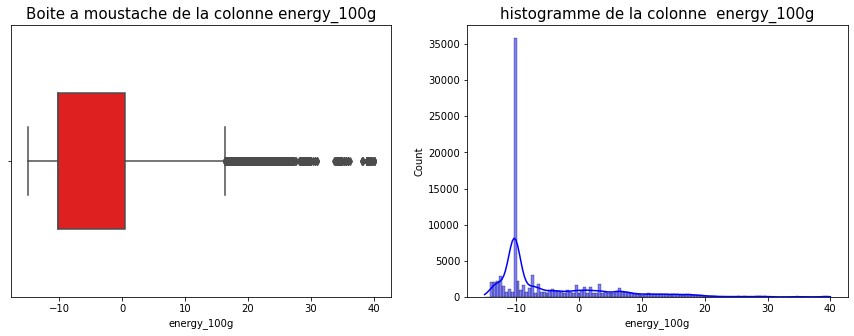

******************************************************************************************************************************************************
Analyse de la colonne nutrition-score-fr_100g
moyenne : 7.7
mediane : 2.19
mode : 0    0.22
Name: nutrition-score-fr_100g, dtype: float64
variance : 108.14
skewness : 0.93
kurtosis : -0.22
ecart type : 10.4
min : -15.0
25% : 0.22
50% : 2.19
75% : 15.2
max : 40.0
Interprétation
la distribution de la colonne nutrition-score-fr_100g est symétrique
la distribution de la colonne nutrition-score-fr_100g est plus aplatie que la distribution normale


<Figure size 432x288 with 0 Axes>

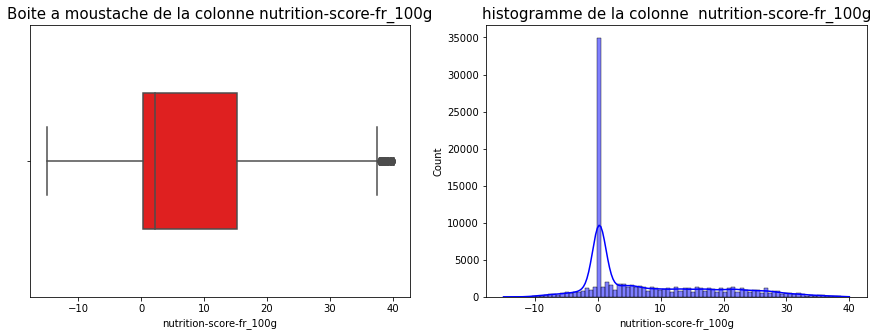

******************************************************************************************************************************************************
Analyse de la colonne sugars_100g
moyenne : -8.8
mediane : -12.53
mode : 0   -12.52
Name: sugars_100g, dtype: float64
variance : 87.96
skewness : 2.36
kurtosis : 5.65
ecart type : 9.38
min : -15.0
25% : -14.18
50% : -12.52
75% : -8.95
max : 40.0
Interprétation
la distribution de la colonne sugars_100g est étalée à droite
la distribution de la colonne sugars_100g est moins aplatie que la distribution normale


<Figure size 432x288 with 0 Axes>

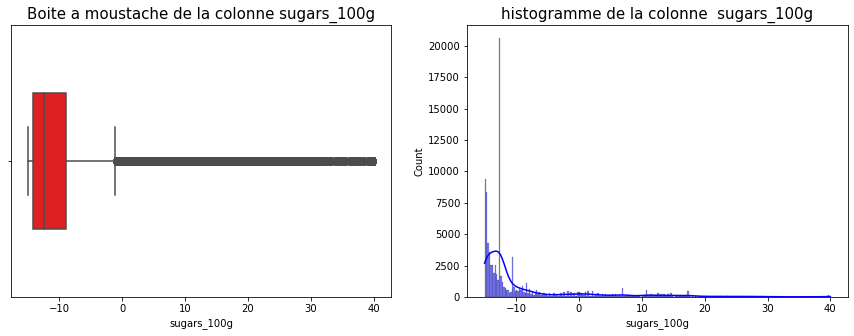

******************************************************************************************************************************************************
Analyse de la colonne salt_100g
moyenne : -14.42
mediane : -14.71
mode : 0   -14.71
Name: salt_100g, dtype: float64
variance : 6.7
skewness : 16.96
kurtosis : 323.58
ecart type : 2.59
min : -15.0
25% : -14.94
50% : -14.71
75% : -14.45
max : 40.0
Interprétation
la distribution de la colonne salt_100g est étalée à droite
la distribution de la colonne salt_100g est moins aplatie que la distribution normale


<Figure size 432x288 with 0 Axes>

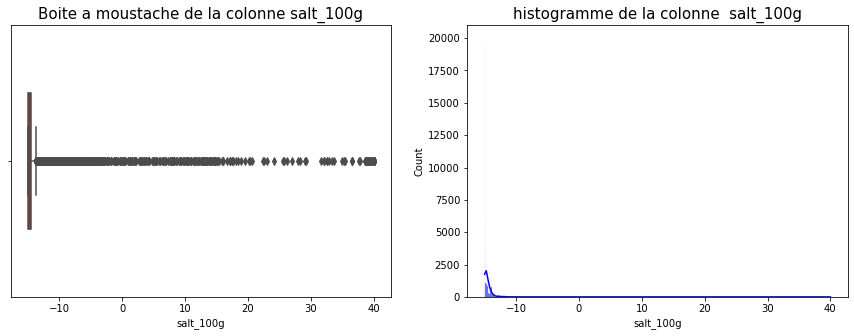

******************************************************************************************************************************************************
Analyse de la colonne fat_100g
moyenne : -10.17
mediane : -13.86
mode : 0   -14.99
Name: fat_100g, dtype: float64
variance : 64.85
skewness : 2.9
kurtosis : 11.16
ecart type : 8.05
min : -15.0
25% : -14.99
50% : -13.86
75% : -8.23
max : 40.0
Interprétation
la distribution de la colonne fat_100g est étalée à droite
la distribution de la colonne fat_100g est moins aplatie que la distribution normale


<Figure size 432x288 with 0 Axes>

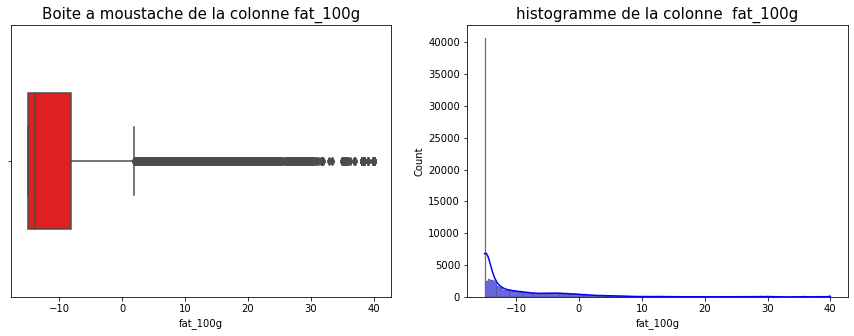

******************************************************************************************************************************************************
Analyse de la colonne fiber_100g
moyenne : 37.98
mediane : 39.75
mode : 0    40.0
Name: fiber_100g, dtype: float64
variance : 15.03
skewness : -5.78
kurtosis : 54.89
ecart type : 3.88
min : -15.0
25% : 37.38
50% : 39.75
75% : 40.0
max : 40.0
Interprétation
la distribution de la colonne fiber_100g est étalée à gauche
la distribution de la colonne fiber_100g est moins aplatie que la distribution normale


<Figure size 432x288 with 0 Axes>

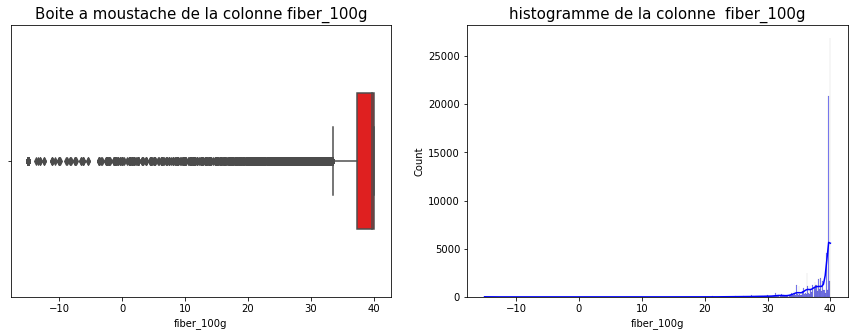

******************************************************************************************************************************************************
Analyse de la colonne proteins_100g
moyenne : 35.52
mediane : 36.14
mode : 0    36.14
Name: proteins_100g, dtype: float64
variance : 19.9
skewness : -2.43
kurtosis : 12.61
ecart type : 4.46
min : -15.0
25% : 34.75
50% : 36.14
75% : 38.74
max : 40.0
Interprétation
la distribution de la colonne proteins_100g est étalée à gauche
la distribution de la colonne proteins_100g est moins aplatie que la distribution normale


<Figure size 432x288 with 0 Axes>

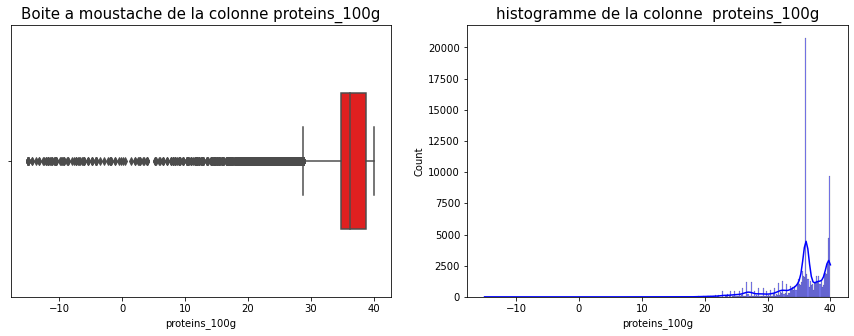

******************************************************************************************************************************************************
Analyse de la colonne additives_n
moyenne : -13.14
mediane : -15.0
mode : 0   -15
Name: additives_n, dtype: int64
variance : 14.41
skewness : 2.8
kurtosis : 10.32
ecart type : 3.8
min : -15
25% : -15.0
50% : -15.0
75% : -13.0
max : 40
Interprétation
la distribution de la colonne additives_n est étalée à droite
la distribution de la colonne additives_n est moins aplatie que la distribution normale


<Figure size 432x288 with 0 Axes>

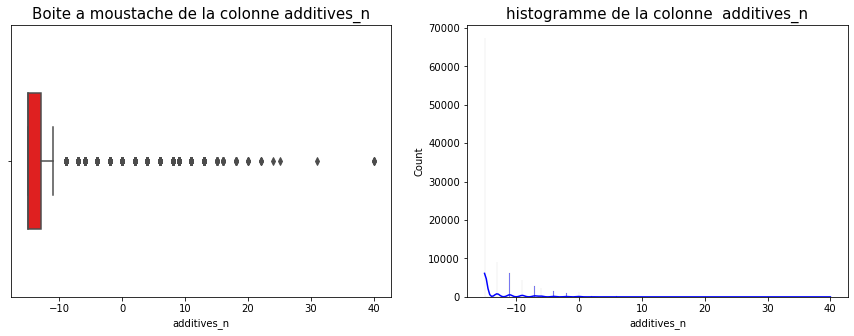

******************************************************************************************************************************************************
Analyse de la colonne score_ecolo_healthy
moyenne : 5.11
mediane : 7.12
mode : 0    7.12
Name: score_ecolo_healthy, dtype: float64
variance : 30.29
skewness : 0.0
kurtosis : -0.7
ecart type : 5.5
min : -8.41
25% : -0.73
50% : 7.12
75% : 8.08
max : 22.97
Interprétation
la distribution de la colonne score_ecolo_healthy est symétrique
la distribution de la colonne score_ecolo_healthy est plus aplatie que la distribution normale


<Figure size 432x288 with 0 Axes>

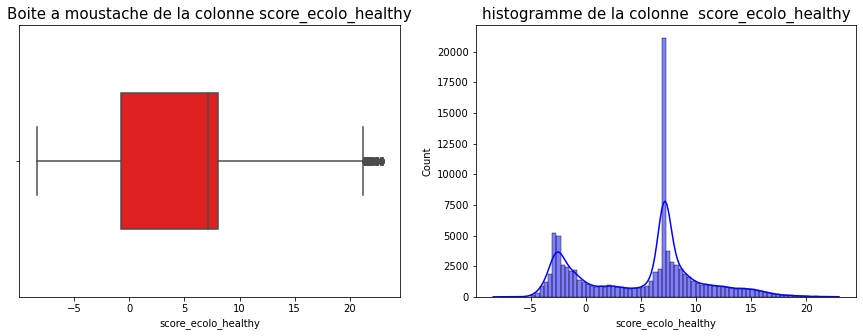

******************************************************************************************************************************************************


<Figure size 432x288 with 0 Axes>

In [7]:
for colonne in colonnes_a_analyser:
    print(colored(150*'*', 'blue', attrs=['bold']))
    print(colored('Analyse de la colonne '+colonne, 'red', attrs=['bold']))
    analyse_univariee(data_france,colonne,str(colonne))
    fichier ='univarie_'+colonne+'.png'
    plt.savefig(fichier)
print(colored(150*'*', 'blue', attrs=['bold']))

**colonnes qualitatives**

**Diagramme camembert**

In [8]:
def camembert_fig(data, colonne, nb_val):
    lab = data[colonne].value_counts().index.values[0:nb_val]
    val = data_france['main_category_fr'].value_counts().values[0:nb_val]

    fig1, ax1 = plt.subplots()
    plt.figure(facecolor=None)
    ax1.pie(val, labels=lab, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal')  
    ax1.set_title('Liste des valeurs',fontsize=15,c='red',fontstyle='italic',ha='center')
    fichier ='camembert_'+colonne+'.png'
    plt.savefig(fichier)
    plt.show()

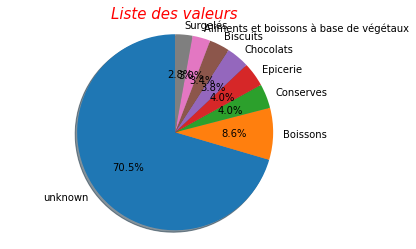

<Figure size 432x288 with 0 Axes>

In [9]:
# Pour une meilleure visibilité, on ne va afficher que 8 valeurs
camembert_fig(data_france,'main_category_fr',8)


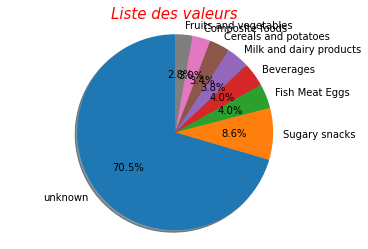

<Figure size 432x288 with 0 Axes>

In [10]:
# Pour une meilleure visibilité, on ne va afficher que 8 valeurs
camembert_fig(data_france,'pnns_groups_1',8)

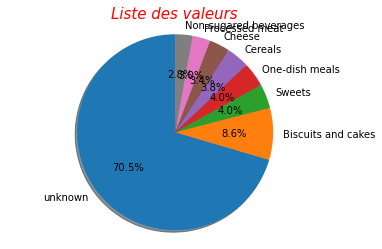

<Figure size 432x288 with 0 Axes>

In [11]:
# Pour une meilleure visibilité, on ne va afficher que 8 valeurs
camembert_fig(data_france,'pnns_groups_2',8)

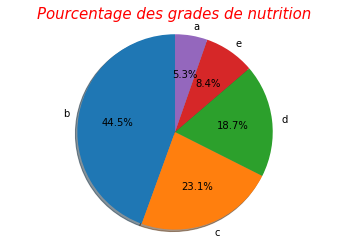

<Figure size 432x288 with 0 Axes>

In [12]:
lab = data_france['nutrition_grade_fr'].value_counts().index.values
val = data_france['nutrition_grade_fr'].value_counts().values
fig1, ax1 = plt.subplots()
plt.figure(facecolor=None)
ax1.pie(val, labels=lab, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Pourcentage des grades de nutrition',fontsize=15,c='red',fontstyle='italic',ha='center')
fichier ='camembert_nutrition_grade'+'.png'
plt.savefig(fichier)
plt.show()

**wordcloud**

In [13]:
def wordcloud_fig (data,colonne):
    text = " ".join(i for i in data[colonne])
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(7,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    fichier ='wordcloud_'+colonne+'.png'
    plt.savefig(fichier)
    plt.show()
    

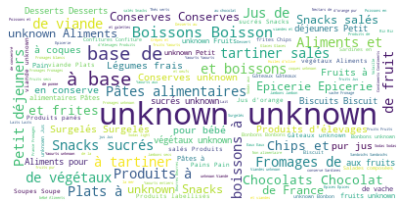

In [14]:
wordcloud_fig (data_france,'main_category_fr')


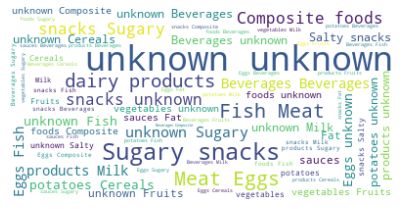

In [15]:
wordcloud_fig (data_france,'pnns_groups_1')


In [16]:
data_france['pnns_groups_1'].value_counts()/data_france['pnns_groups_1'].value_counts().sum()*100

unknown                    47.621510
Sugary snacks               9.732161
Fish Meat Eggs              7.004137
Beverages                   6.822130
Milk and dairy products     6.646329
Cereals and potatoes        6.338159
Composite foods             4.437435
Fruits and vegetables       4.217166
Fat and sauces              3.927611
Salty snacks                2.195450
fruits-and-vegetables       0.567735
sugary-snacks               0.488108
cereals-and-potatoes        0.002068
Name: pnns_groups_1, dtype: float64

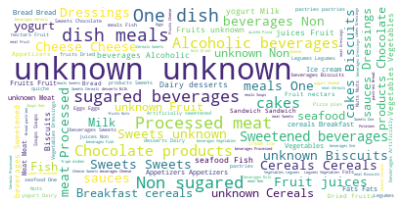

In [17]:
wordcloud_fig (data_france,'pnns_groups_2')


In [18]:
data_france['pnns_groups_2'].value_counts()/data_france['pnns_groups_2'].value_counts().sum()*100

unknown                             45.390900
Biscuits and cakes                   3.891417
Sweets                               3.549121
One-dish meals                       3.538780
Cereals                              3.152017
Cheese                               3.133402
Processed meat                       3.007239
Non-sugared beverages                2.982420
Dressings and sauces                 2.701138
Chocolate products                   2.291624
Fish and seafood                     2.261634
Alcoholic beverages                  2.164426
Milk and yogurt                      2.131334
Vegetables                           1.833506
Sweetened beverages                  1.716649
Appetizers                           1.682523
Fruit juices                         1.584281
Fruits                               1.552223
Meat                                 1.403309
Bread                                1.360910
Fats                                 1.226474
Breakfast cereals                 

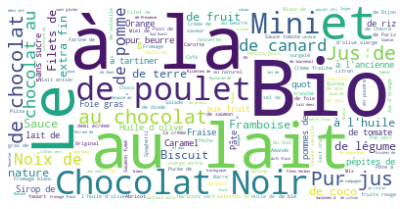

In [19]:
wordcloud_fig (data_france,'product_name')

# Analyse bivariée

**colonnes qualitatives / quantitatives**

Je vais m'interrésser à la colonne 'nutrition_grade_fr' en fonction des colonnes quantitatives

In [20]:
colonnes_a_analyser.append('nutrition_grade_fr')

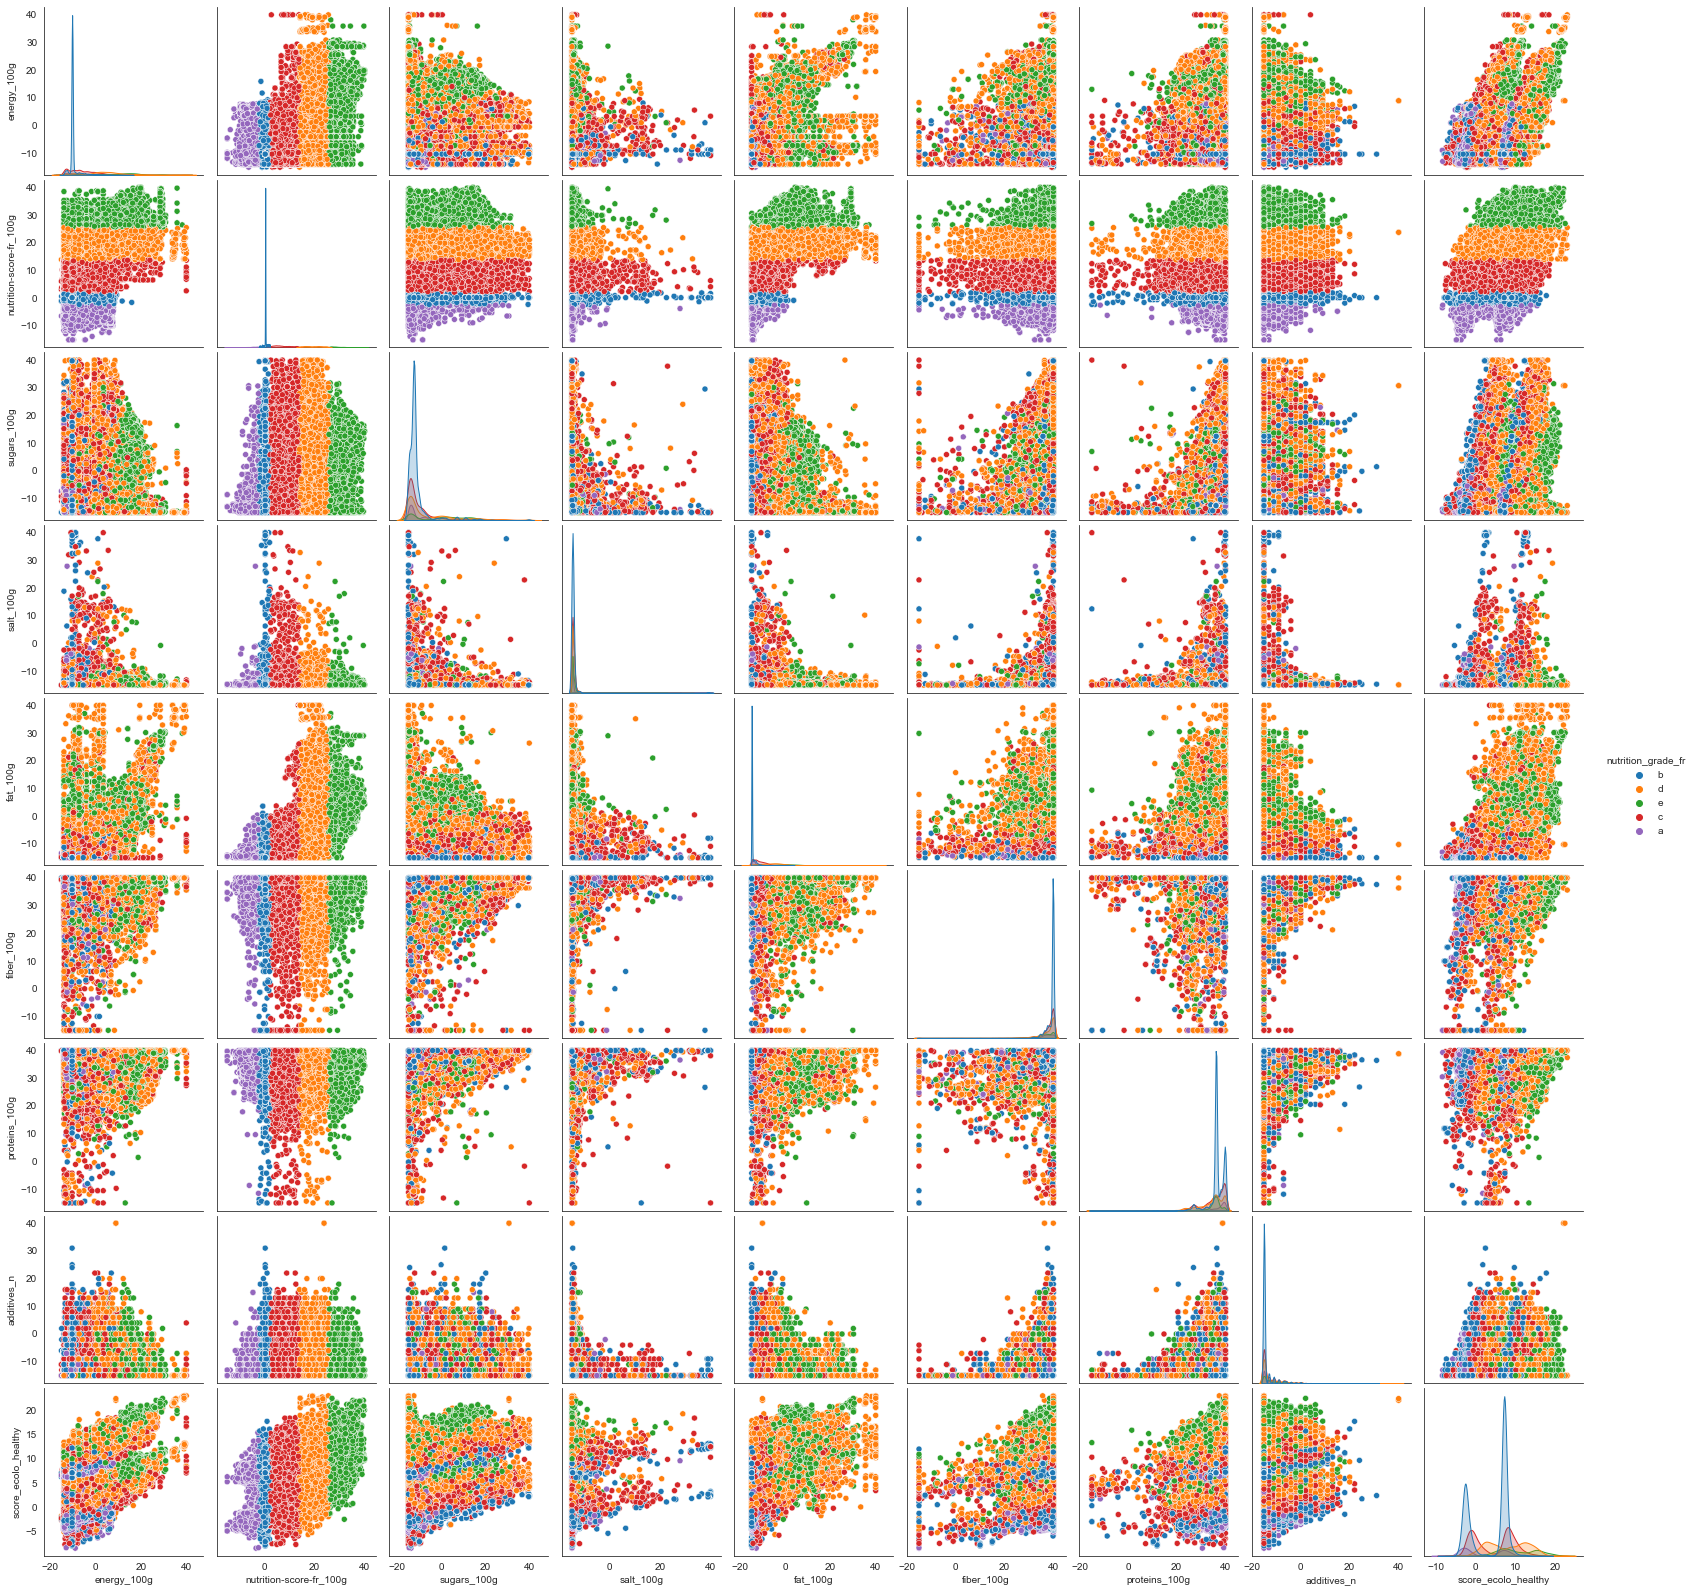

In [21]:
# Graphique représentant un nuage de points des données numeriques par grade (a,b,c,d,e)

sns.set_style("white")
sns.pairplot(data_france[colonnes_a_analyser], kind='scatter', hue='nutrition_grade_fr')
fichier ='nuage_points_nutrition_grade'+'.png'
plt.savefig(fichier)
plt.show()

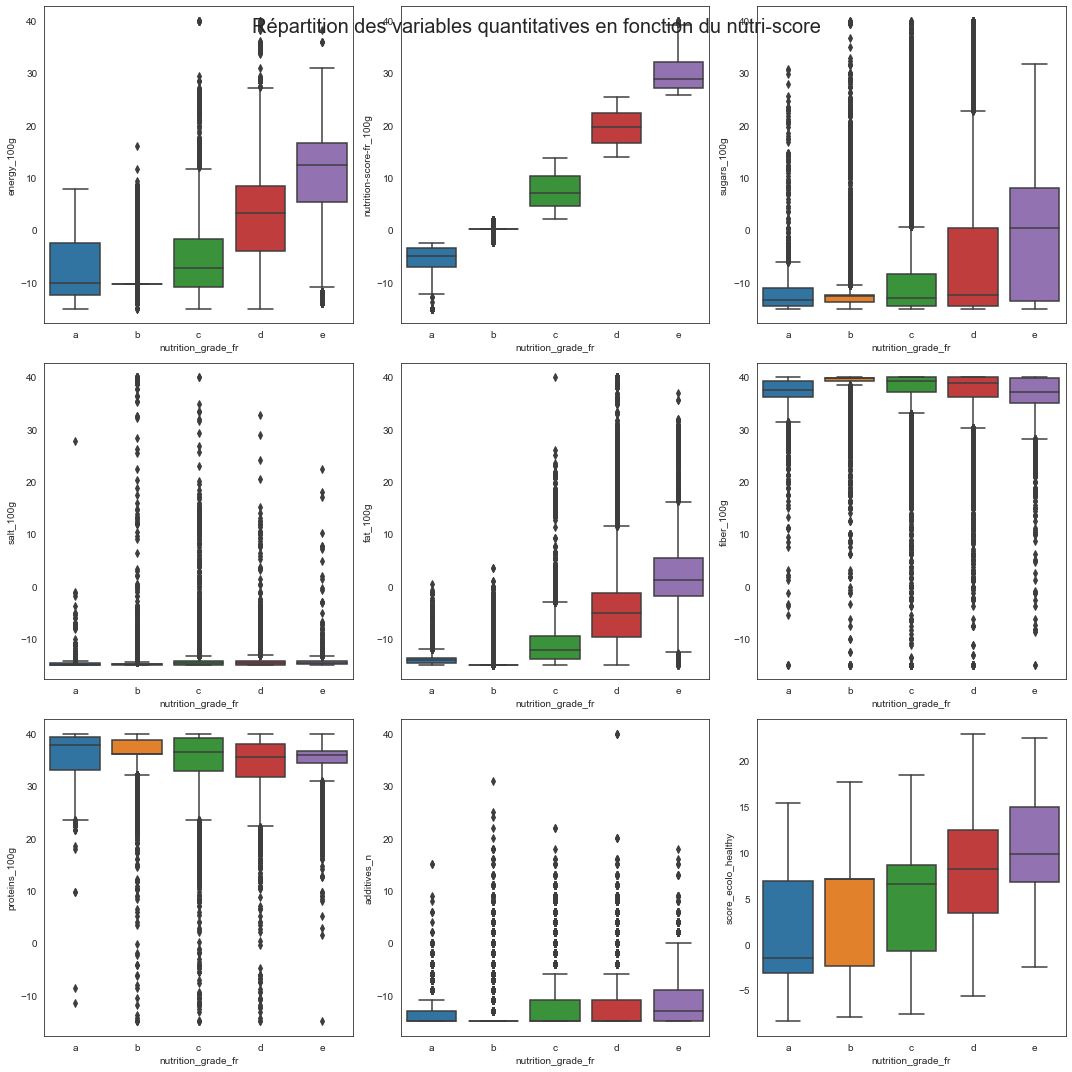

In [22]:
# Graphique représentant les boites à moustaches des données numeriques par grade (a,b,c,d,e)
fig = plt.figure(figsize=(15, 15))

for i, c in enumerate(colonnes_numeriques, 1):
    ax = fig.add_subplot(3, 3, i)
    sns.boxplot(data=data_france, x='nutrition_grade_fr', y=c,order=list('abcde'), ax=ax)
    plt.grid(False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.suptitle('Répartition des variables quantitatives en fonction du nutri-score', fontsize=20)
fichier ='nuage_moustaches_nutrition_grade'+'.png'
plt.savefig(fichier)

plt.show()

D'aprés ces deux graphiques 
Plus un produit contient de sel, sucre ou additifs, moins est meilleure sa grade.

Plus un produit est énergique, moins est sa grade.

Plus un produit contient de fibres ou de protéines, plus est meilleure sa grade.

Ceci explique bien la définition du score de nutrition.

Il y a bien une relation de dépendance entre la variable 'nutrition_grade_fr' et toutes les variables quantitatives

**Anova 'score_ecolo_healthy' / 'nutrition_grade_fr**

Dans une ANOVA, on cherche à déterminer si les moyennes des groupes sont significativement différentes. On pose donc :

H0 : Les moyennes de chaque groupe sont égales si p-value > 5%

H1 : Les moyennes de chaque groupe ne sont pas toutes égales si p-value < 5%

In [23]:
# Anova en utilisant la bibliotheque statsmodels

model = ols('score_ecolo_healthy ~ nutrition_grade_fr', data=data_france).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df            F  PR(>F)
nutrition_grade_fr  5.925720e+05      4.0  6131.069888     0.0
Residual            2.336409e+06  96695.0          NaN     NaN

p_value = 0, on rejète H0 et on garde H1. Il y a bien une corrélation entre les deux variables.

la pertinence de ce test repose sur la validation de plusieurs hypothèses :

l’indépendance entre les échantillons de chaque groupe

l’égalité des variances que l’on peut verifier avec un test de Bartlett.

la normalité des résidus avec un test de Shapiro.

 **Indépendance**

On va supposer que les groupes (a,b,c,d et e) sont indépendants

**égalité des variances**

In [24]:
# Test Bartlett

bartlett(data_france.score_ecolo_healthy[data_france.nutrition_grade_fr == 'a'],
        data_france.score_ecolo_healthy[data_france.nutrition_grade_fr == 'b'],
        data_france.score_ecolo_healthy[data_france.nutrition_grade_fr == 'c'],
        data_france.score_ecolo_healthy[data_france.nutrition_grade_fr == 'd'],
        data_france.score_ecolo_healthy[data_france.nutrition_grade_fr == 'e'])

BartlettResult(statistic=213.5598695032418, pvalue=4.556186319819332e-45)

p_value<5% donc les variances de chaque groupe ne sont pas toutes égales. La deuxième condition pour effectuer une anova est validée.

**Normalité des résidus**

In [25]:
# Test Shapiro
model = ols('score_ecolo_healthy ~ nutrition_grade_fr', data=data_france).fit()
shapiro(model.resid)

ShapiroResult(statistic=0.8913649916648865, pvalue=0.0)

p_value = 0 donc les résidus ne suivent pas une loi normale

**colonnes quantitatives / quantitatives**

Je vais m'intérresser à la colonne 'score_ecolo_healthy' en fonctions des colonnes quantitatives

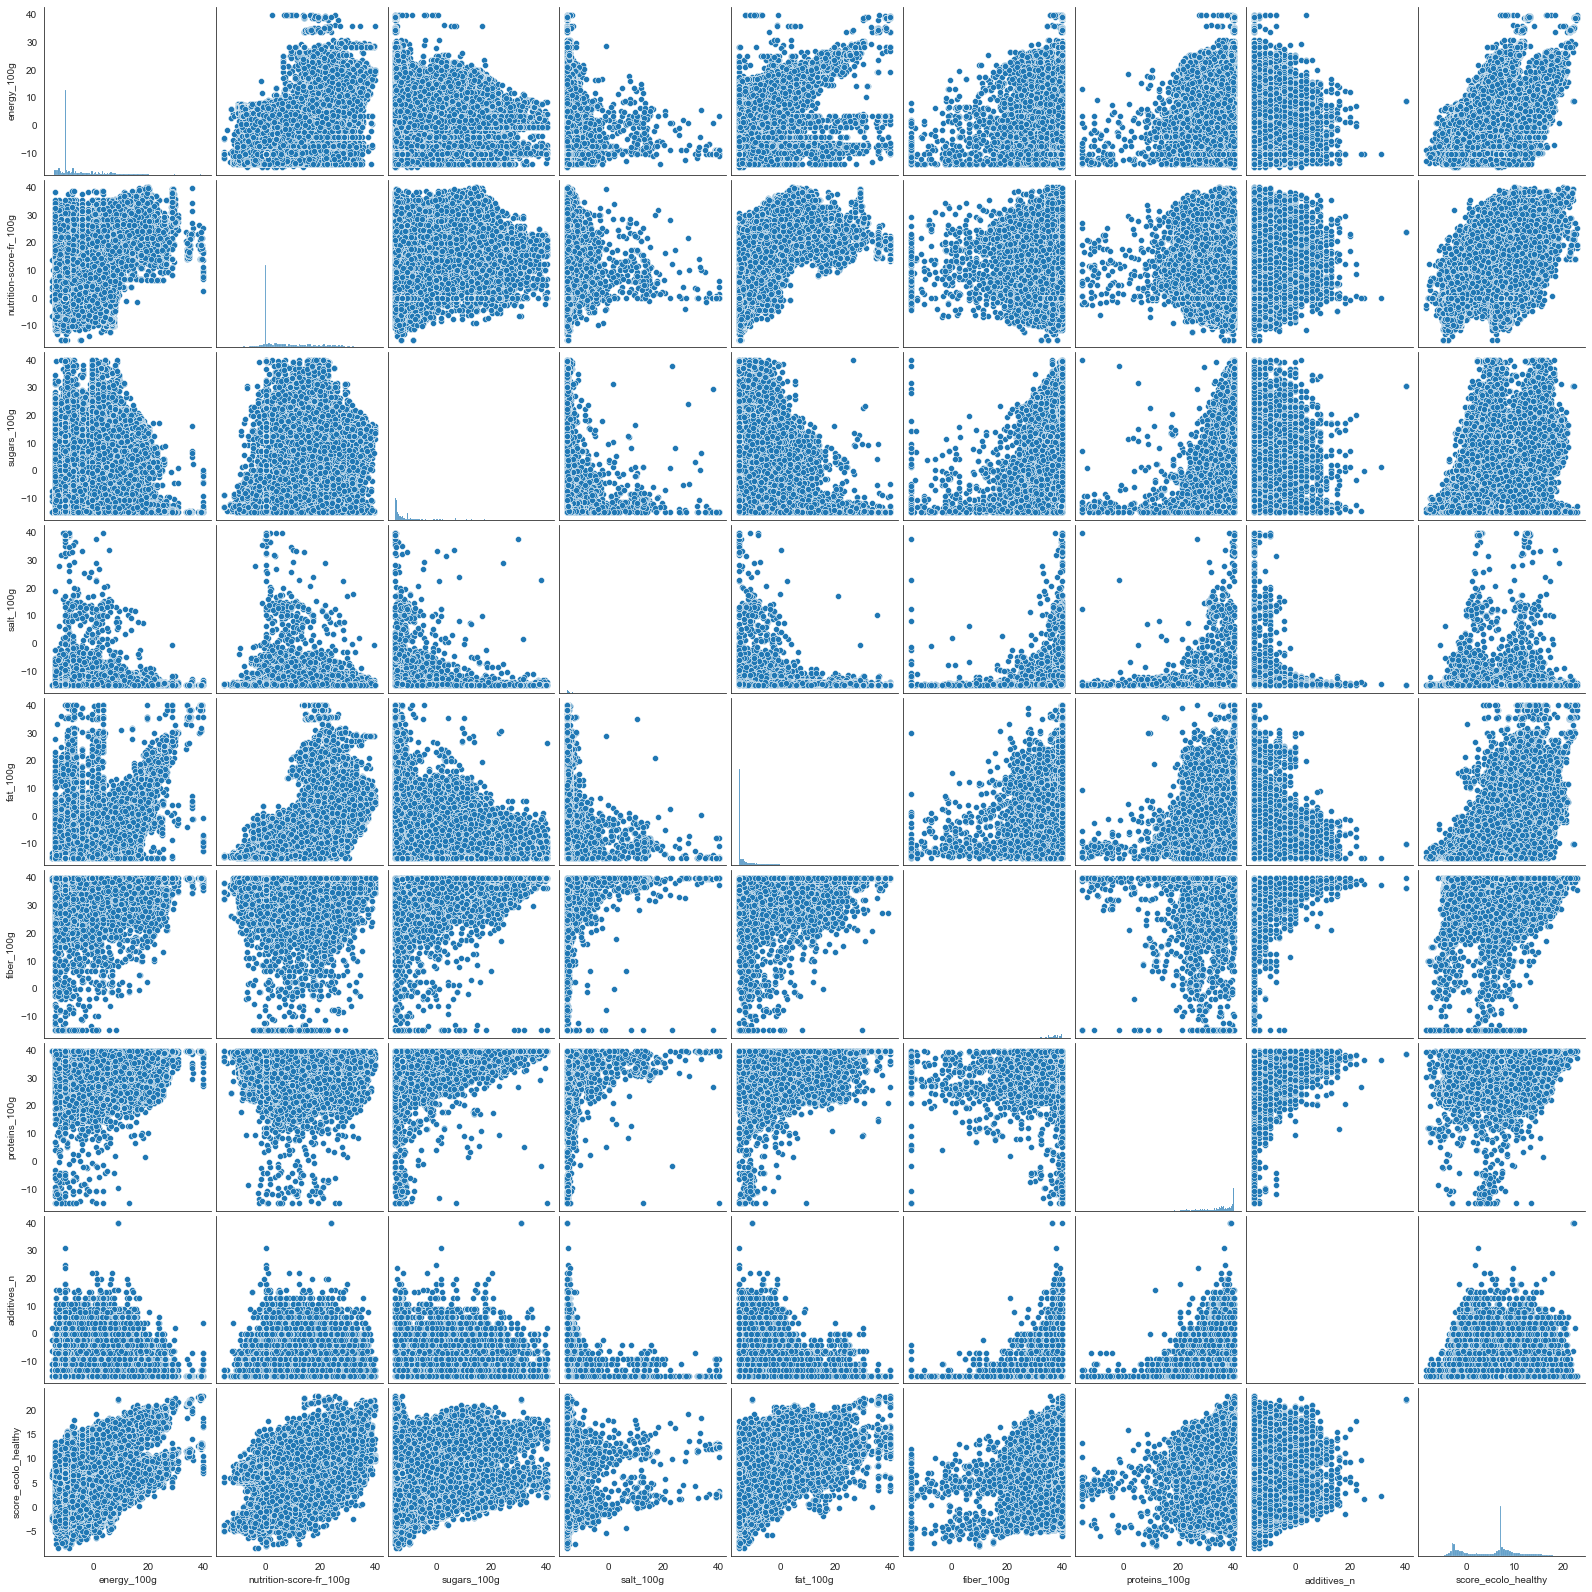

In [26]:
# Graphique représentant un nuage de points entre les données numeriques par pair de 2
sns.pairplot(data_france[colonnes_a_analyser])
fichier ='nuage_points_donnees_numeriques'+'.png'
plt.savefig(fichier)




**Matrice de correlation**

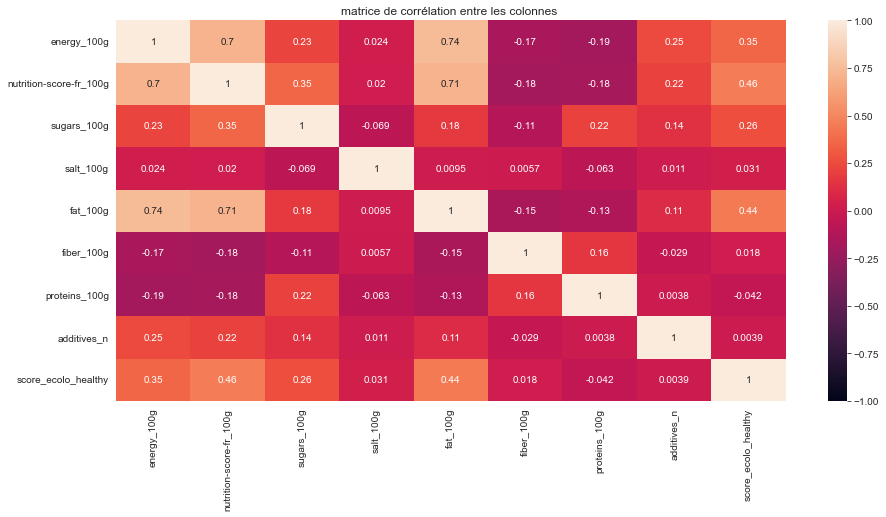

In [27]:
plt.rcParams["figure.figsize"]=[15,7]
data = data_france[colonnes_a_analyser]
sns.heatmap(data.corr(), vmin=-1, vmax=1,annot=True,)
plt.title('matrice de corrélation entre les colonnes ')
fichier ='heatmap_fr'+'.png'
plt.savefig(fichier)
plt.show()

D'aprés le graphique du nuage de point et la matrice de corrélation nous remarquons :

Il y a une corrélation (positive) entre le nouveu score et les variables nutrition-score-fr_100g,	energy_100g,	sugars_100g,	salt_100g	 et fat_100g. Plus un produit contient un element de cette liste, plus le score est supérieur, plus sa grade de nutrition est mauvaise.

Il y a une corrélation (négative) entre le nouveu score et la variable	proteins_100g. Plus un produit contient de proteies, plus le score est inférieyr, plus sa grade de nutrition est meilleure.

Il y a une forte corrélation entre les 2 varaibles fat_100g et  energy_100g. Les produits contenant plus de graisses  sont trés energitiques.


**colonnes qualitatives / qualitatives**

Je vais m'interrésser à la colonne 'nutrition_grade_fr' en fonction des colonnes qualitatives

**Test du Khi²**

L'intérêt du test du Khi² est de mesurer l'indépendance entre deux variables qualitatives à partir du tableau de contigence (cross-table).

On pose les hypothèses de départ :

H0 : Variables indépendantes si p-value > 5%

H1 : Variables non indépendantes si p-value < 5%



In [28]:
# Test d'inependence Chi-square 
def test_chi2(cross_table):
  test_statistic, p_values, degrees_freedom, expected = chi2_contingency(cross_table) 
  # Résultats du test
  print('test statistic :',test_statistic)
  print('p_values du test :',p_values)
  print('degrees of freedom :',degrees_freedom)
  if p_values <0.05:
    print ('Il y a une corrélation entre les deux variables')


In [29]:
table_grade_emballages = pd.crosstab(data_france['packaging'], data_france['nutrition_grade_fr'])
table_grade_emballages

nutrition_grade_fr     a      b      c     d     e
packaging                                         
-15                 3001  16494  10678  8782  4425
 40                 2170  26499  11673  9304  3674

In [30]:
# Test d'inependence Chi-square 'nutrition_grade_fr' et 'packaging'
test_chi2(table_grade_emballages) 


test statistic : 1585.8327371172684
p_values du test : 0.0
degrees of freedom : 4
Il y a une corrélation entre les deux variables


In [31]:
table_grade_category = pd.crosstab(data_france['main_category_fr'], data_france['nutrition_grade_fr'])
table_grade_category

nutrition_grade_fr     a      b     c     d     e
main_category_fr                                 
A-code-1               0      1     0     0     0
Ab                     0      1     0     0     0
Abats-surgeles         0      1     0     0     0
Abdijbier              0      1     0     0     0
Accras-de-morue        0      3     0     0     0
...                  ...    ...   ...   ...   ...
unknown              897  21564  6963  5253  1808
vi:Gia-vị              0      1     0     0     0
xx:Barre-chocolatee    0      0     0     0     1
zh:Sauce-de-soja       0      1     0     0     0
Édulcorants            2     36    41    45     1

[1613 rows x 5 columns]

In [32]:
# Test d'inependence Chi-square nutrition_grade_fr	et main_category_fr
test_chi2(table_grade_category) 

test statistic : 72493.72907847835
p_values du test : 0.0
degrees of freedom : 6448
Il y a une corrélation entre les deux variables


In [33]:
table_grade_pnns_groups1 = pd.crosstab(data_france['pnns_groups_1'], data_france['nutrition_grade_fr'])
table_grade_pnns_groups1

nutrition_grade_fr          a      b     c     d     e
pnns_groups_1                                         
Beverages                 292   3030  2459   780    36
Cereals and potatoes     1474   1723  1882   906   144
Composite foods           231   1495  1931   586    48
Fat and sauces            114   1103   741  1264   576
Fish Meat Eggs            243   2423  2247  1287   573
Fruits and vegetables    1200   1943   717   194    24
Milk and dairy products   191   1825  1935  2219   257
Salty snacks                3    254   212  1065   589
Sugary snacks              52   1918  1250  2762  3429
cereals-and-potatoes        1      1     0     0     0
fruits-and-vegetables     185    266    90     8     0
sugary-snacks               0     93    42   297    40
unknown                  1185  26919  8845  6718  2383

In [34]:
# Test d'inependence Chi-square entre nutrition_grade_fr	et pnns_groups_1
test_chi2(table_grade_pnns_groups1) 


test statistic : 35401.01528866264
p_values du test : 0.0
degrees of freedom : 48
Il y a une corrélation entre les deux variables


In [35]:
table_grade_pnns_groups2 = pd.crosstab(data_france['pnns_groups_2'], data_france['nutrition_grade_fr'])
table_grade_pnns_groups2

nutrition_grade_fr                   a      b     c     d     e
pnns_groups_2                                                  
Alcoholic beverages                  7   2015    56    15     0
Appetizers                           2    162   167   768   528
Artificially sweetened beverages    15    140    48     5     3
Biscuits and cakes                  23    469   265  1299  1707
Bread                               57    443   564   211    41
Breakfast cereals                   50    169   423   431    40
Cereals                           1196    831   748   219    54
Cheese                              31    447   574  1775   203
Chocolate products                   4    383    86   483  1260
Dairy desserts                      30    211   422    73    10
Dressings and sauces               114    930   692   605   271
Dried fruits                         5     90   158   106    18
Eggs                                57    236    28     0     0
Fats                                 0    173    49   659   305
Fish and seafood                   120    745   884   396    42
Fruit juices                        75    343   926   188     0
Fruit nectars                       11     69   180    50     0
Fruits                             472    742   231    52     4
Ice cream                            5    113   260   172    40
Legumes                            151    213   134    42     8
Meat                                58    685   489   108    17
Milk and yogurt                    125   1054   679   199     4
Non-sugared beverages              114   2123   482   150    15
Nuts                                 1     92    43   289    56
One-dish meals                     231   1396  1491   274    30
Pizza pies and quiche                0     24   124    73     4
Potatoes                            20     67    13     3     1
Processed meat                       8    757   846   783   514
Salty and fatty products             0      0     2     8     5
Sandwich                             0     75   316   239    14
Soups                               69    276    77     5     0
Sweetened beverages                 77    355   823   387    18
Sweets                              25   1066   899   980   462
Tripe dishes                         2     26    18    18     0
Vegetables                         654    835   251    31     2
cereals                              1      0     0     0     0
fruits                               6     13     4     2     0
legumes                              0      1     0     0     0
pastries                             0     93    42   297    40
unknown                           1176  24878  8771  6685  2383
vegetables                         179    253    86     6     0

In [36]:
# Test d'inependence Chi-square entre nutrition_grade_fr	et pnns_groups_2
test_chi2(table_grade_pnns_groups2) 

test statistic : 54185.750538199674
p_values du test : 0.0
degrees of freedom : 160
Il y a une corrélation entre les deux variables


# Analyse multivariée

**Analyse en composantes principales (ACP)**

In [37]:
data_france_acp = data_france[colonnes_numeriques].copy()

In [38]:
data_france_acp.isnull().mean()

energy_100g                0.0
nutrition-score-fr_100g    0.0
sugars_100g                0.0
salt_100g                  0.0
fat_100g                   0.0
fiber_100g                 0.0
proteins_100g              0.0
additives_n                0.0
score_ecolo_healthy        0.0
dtype: float64

In [39]:
pca = decomposition.PCA(n_components=len(colonnes_numeriques))
pca.fit(data_france_acp)
#pca.fit(data_france_acp_scaler)

data_france_acp1 = pca.transform(data_france_acp)


print("Composantes principales : ")
print(pca.components_)

Composantes principales : 
[[ 0.52510569  0.63158065  0.28330389  0.0016806   0.44768319 -0.05125335
  -0.04421585  0.05915988  0.19132144]
 [-0.23590623 -0.05068071  0.91984452 -0.02549964 -0.23571713 -0.00553094
   0.19310911  0.02085684  0.04118563]
 [ 0.65495519 -0.58604232  0.15934032 -0.01981204  0.1165369  -0.0527421
   0.09768774  0.12286965 -0.40100352]
 [-0.0381166  -0.42027114 -0.00316438 -0.0050901   0.44813082  0.22979597
   0.29765843 -0.2355172   0.65129644]
 [ 0.30754394 -0.18044927  0.06602737  0.04876399 -0.44070541 -0.06050308
  -0.63129496  0.01068221  0.51921858]
 [-0.25258535 -0.15603506  0.14799609 -0.0192427   0.43843169 -0.54315182
  -0.45884951 -0.40676259 -0.16231345]
 [ 0.01203855 -0.02857647 -0.1324259   0.00507366 -0.10742295 -0.78911999
   0.38797053  0.34328391  0.28082216]
 [-0.28206332 -0.14377146  0.06138839  0.0133623   0.36204857  0.14262242
  -0.3192794   0.8010735   0.0272865 ]
 [-0.01028631 -0.00825733  0.02565167  0.99798598  0.02350852 -0.00534

In [40]:
# pourcentage d'informations représentées par chacune des composantes pca
print ( pd.DataFrame(pca.explained_variance_ratio_*100))

           0
0  53.623410
1  18.598084
2   6.659592
3   5.841719
4   4.232358
5   4.010061
6   2.825131
7   2.679713
8   1.529932


In [41]:
# pourcentage d'informations cumulées des composantes pca
print ( pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)*100))

            0
0   53.623410
1   72.221495
2   78.881087
3   84.722805
4   88.955163
5   92.965224
6   95.790356
7   98.470068
8  100.000000


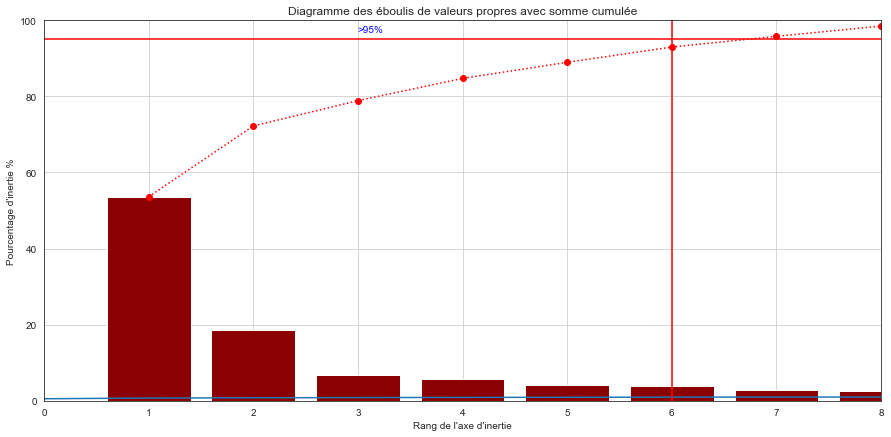

In [42]:
# diagramme d’éboulis des valeurs propres
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(1,len(cumsum)+1),cumsum*100,'o:',color='red')
plt.xlim(0,8)
plt.ylim(0,100)
plt.grid()
plt.xlabel('Rang de l\'axe d\'inertie')
plt.ylabel('Pourcentage d\'inertie %')

#  trouver le moment où on attient 95% d'informations
plt.plot(cumsum)
# argmax pour > 95 %
nb_composantes_arret = np.argmax(cumsum > 0.95)
plt.axhline(y=95, color='r')
plt.text(3, 97, '>95%', color='b', fontsize=10)
plt.axvline(x=nb_composantes_arret, color='r')


plt.title('Diagramme des éboulis de valeurs propres avec somme cumulée')
plt.bar(np.arange(1,len(cumsum)+1),pca.explained_variance_ratio_*100,color='darkred')
fichier ='diagramme_eboulis'+'.png'
plt.savefig(fichier)

In [43]:
data_france_acp1 = pd.DataFrame(data_france_acp1, columns=data_france_acp.columns.to_list())
data_france_acp1.head()

energy_100g  nutrition-score-fr_100g  sugars_100g  salt_100g  fat_100g  \
0   -10.780162                -0.395733    -1.575067   3.555563  1.979166   
1   -11.641744                -1.916710    -1.649281   4.849821 -0.584299   
2   -10.780162                -0.395733    -1.575067   3.555563  1.979166   
3    26.825195                19.350599     1.812039   4.171741  4.995590   
4   -10.780162                -0.395733    -1.575067   3.555563  1.979166   

   fiber_100g  proteins_100g  additives_n  score_ecolo_healthy  
0   -0.863891      -0.070480    -0.678258            -0.406115  
1   -3.149789       1.589028    -2.026267            -0.634182  
2   -0.863891      -0.070480    -0.678258            -0.406115  
3   -1.806130       0.981912    -2.777679            -0.270700  
4   -0.863891      -0.070480    -0.678258            -0.406115

La première composante du pca résume plus de 50% de l'informations.Les trois dernières composantes résument peu d'informations(< 3%).
Nous pouvons retenir seulement 6 composantes (on perd seulement 5% d'informations) et comme ça on arrive à réduire le nombre de variables de 8 à 6.

In [44]:
df_acp = pd.DataFrame(pca.components_.round(2),
                      index=['pc'+str(i+1) for i in range(len(colonnes_numeriques))],
                      columns=colonnes_numeriques).T
df_acp

pc1   pc2   pc3   pc4   pc5   pc6   pc7   pc8   pc9
energy_100g              0.53 -0.24  0.65 -0.04  0.31 -0.25  0.01 -0.28 -0.01
nutrition-score-fr_100g  0.63 -0.05 -0.59 -0.42 -0.18 -0.16 -0.03 -0.14 -0.01
sugars_100g              0.28  0.92  0.16 -0.00  0.07  0.15 -0.13  0.06  0.03
salt_100g                0.00 -0.03 -0.02 -0.01  0.05 -0.02  0.01  0.01  1.00
fat_100g                 0.45 -0.24  0.12  0.45 -0.44  0.44 -0.11  0.36  0.02
fiber_100g              -0.05 -0.01 -0.05  0.23 -0.06 -0.54 -0.79  0.14 -0.01
proteins_100g           -0.04  0.19  0.10  0.30 -0.63 -0.46  0.39 -0.32  0.03
additives_n              0.06  0.02  0.12 -0.24  0.01 -0.41  0.34  0.80 -0.02
score_ecolo_healthy      0.19  0.04 -0.40  0.65  0.52 -0.16  0.28  0.03 -0.03

In [45]:
def cercle_correlation(pca, features, x, y):
    fig, ax = plt.subplots(figsize=(10, 9))
    for i in range(0, pca.components_.shape[1]):
        ax.arrow(0,
                 0,  # Start the arrow at the origin
                 pca.components_[x, i],  #0 for PC1
                 pca.components_[y, i],  #1 for PC2
                 head_width=0.07,
                 head_length=0.07, 
                 width=0.02,              )

        plt.text(pca.components_[x, i] + 0.05,
                 pca.components_[y, i] + 0.05,
                 features[i])

    # affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')


    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
    plt.axis('equal')
    fichier ="cercle_corrélation_F{}_F{})".format(x+1, y+1)+'.png'
    plt.savefig(fichier)
    plt.show(block=False)

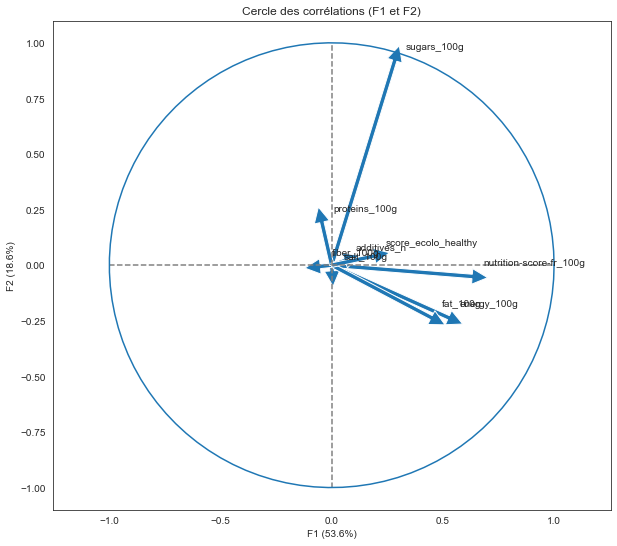

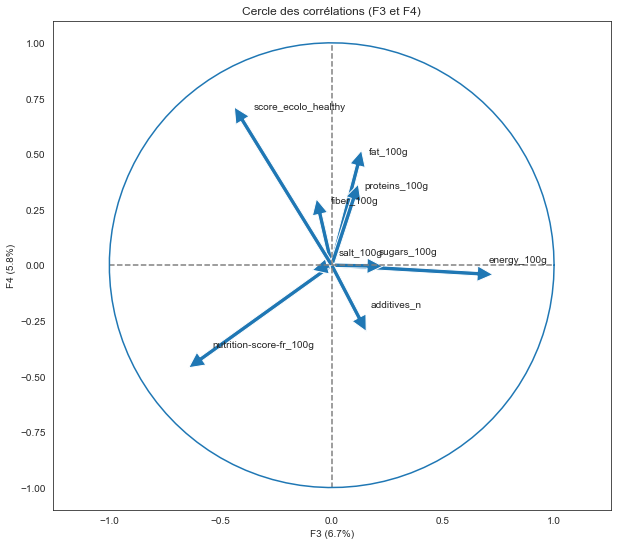

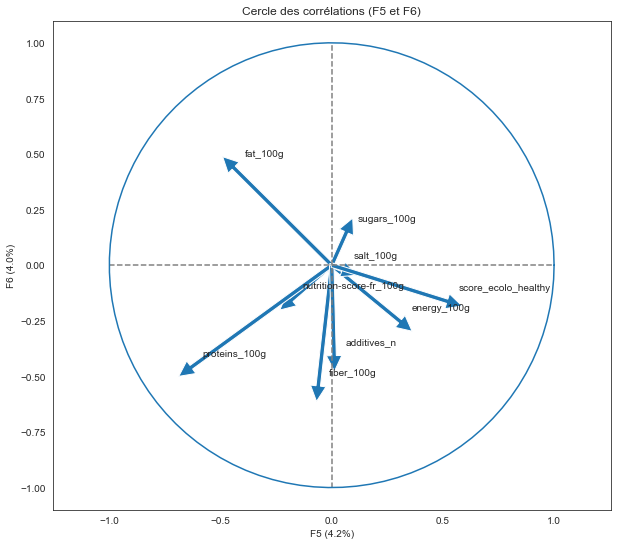

In [46]:
# On ne va afficher le cercle de corrélation que pour 3 plans (F1-F2,F3-F4,F5-F6)
i=0
while i < 5:
    cercle_correlation(pca,colonnes_numeriques,i,i+1)
    i=i+2

D'aprés les cercles de corrélations, nous remarquons :

L'axe F1 contient les produits énergitiques et les produits ayant un meilleur score de nutrition

L'axe F2 contient les produits sucrés

L'axe F3  contient les produits energitiques et les produits ayant moins de score.

L'axe F4 contient les produits contenant plus de graisses et les produits ayant plus de score ecolo_healthy.

L'axe F5 contient les produits ayant plus de score ecolo_healthy et les produits contenat moins de proteines.

L'axe F6 contient les produits contenant plus de graisses et les produits contenat moins de fibres.



# Demo d'application de recommandation des produits

In [47]:

def  recommandation(groupe_produit):
    # Afficher les score des 5 meilleurs produits recommandés

    plt.figure(figsize=(10, 5))
    pff =data_france[data_france['main_category_fr'] == groupe_produit][['image_url','product_name','score_ecolo_healthy']]
    index_healthy = pff['score_ecolo_healthy'].sort_values(ascending=True)[:5].index.to_list()
    pff = pd.DataFrame(pff.loc[index_healthy,'score_ecolo_healthy'].to_list(), index = pff.loc[index_healthy,'product_name'].to_list())
    
    pff.plot.bar(legend=None)
    plt.title('Les 5 meilleurs produits recommandés',fontsize=15)
    fichier ='score_meilleurs_5produits'+'.png'
    plt.savefig(fichier)
    plt.show()
    

    # Afficher les noms et images des 5 produits recommandés
    for i in index_healthy:
        url_image = data_france.loc[i,'image_url']
        display(data_france.loc[i,'product_name'])
        if url_image == 'image de produit non disponible':
          print(url_image)
        else:
          display(Image(url= url_image, width = 100, height = 120))
        print(150*'*')

# Milk and yogurt, Vegetables, Chocolate products

Liste des groupes de produits disponibles : 
 ['unknown', 'Boissons', 'Conserves', 'Epicerie', 'Chocolats', 'Biscuits', 'Aliments et boissons à base de végétaux', 'Surgelés', 'Petit-déjeuners', 'Desserts', 'Snacks sucrés', 'Plats à base de viande', 'Pains', 'Pâtes alimentaires', 'Gâteaux', 'Produits à tartiner salés', 'Fromages', 'Chips et frites', 'Bonbons', 'Soupes', 'Confitures', 'Snacks salés', 'Fromages de France', 'Condiments', "Produits d'élevages", 'Sandwichs', 'Volailles', 'Viandes', 'Légumes frais', 'Glaces', 'Laits', 'Fruits à coques', 'Fruits', 'Eaux', 'Aliments pour bébé', 'Epices', 'Yaourts', 'Jambons', 'Sodas', 'Fromages de vache', 'Saucissons', 'Saucisses', 'Riz', 'Produits labellisés', 'Beurres', 'Jus de fruits', 'Produits panés', 'Charcuteries', 'Saumons', 'Crèmes', 'Sardines en conserve', 'Salades composées', 'Nectars de fruits', 'Poissons', 'Pâtes à tartiner', 'Jus de fruits 100% pur jus', 'Fruits secs', 'Thons', 'Yaourts aux fruits', 'Produits de la mer', 'Huiles',

<Figure size 720x360 with 0 Axes>

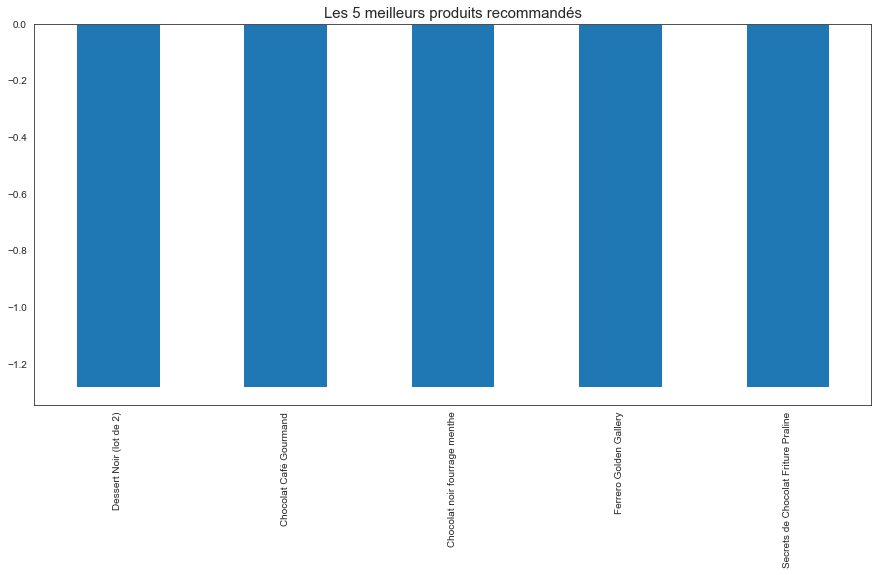

'Dessert Noir (lot de 2)'

******************************************************************************************************************************************************


'Chocolat Café Gourmand'

image de produit non disponible
******************************************************************************************************************************************************


'Chocolat noir fourrage menthe'

******************************************************************************************************************************************************


'Ferrero Golden Gallery'

******************************************************************************************************************************************************


'Secrets de Chocolat Friture Praline'

******************************************************************************************************************************************************


In [49]:
# Chocolats
liste_groupe_produits = data_france['main_category_fr'].value_counts().index.to_list()[:100]
print ('Liste des groupes de produits disponibles : \n', liste_groupe_produits)
print(100*'*')
groupe_produit = input('Choisir le nom du produit que vous voulez acheter de cette liste :\n')
print(100*'*')
if  groupe_produit in liste_groupe_produits:
    print('La categorie du produit que vous avez choisi est :', groupe_produit)
    recommandation(groupe_produit)
else:
    print('La categorie du produit que vous avez choisi n\'est pas dans la liste donnée')
    


Liste des groupes de produits disponibles : 
 ['unknown', 'Boissons', 'Conserves', 'Epicerie', 'Chocolats', 'Biscuits', 'Aliments et boissons à base de végétaux', 'Surgelés', 'Petit-déjeuners', 'Desserts', 'Snacks sucrés', 'Plats à base de viande', 'Pains', 'Pâtes alimentaires', 'Gâteaux', 'Produits à tartiner salés', 'Fromages', 'Chips et frites', 'Bonbons', 'Soupes', 'Confitures', 'Snacks salés', 'Fromages de France', 'Condiments', "Produits d'élevages", 'Sandwichs', 'Volailles', 'Viandes', 'Légumes frais', 'Glaces', 'Laits', 'Fruits à coques', 'Fruits', 'Eaux', 'Aliments pour bébé', 'Epices', 'Yaourts', 'Jambons', 'Sodas', 'Fromages de vache', 'Saucissons', 'Saucisses', 'Riz', 'Produits labellisés', 'Beurres', 'Jus de fruits', 'Produits panés', 'Charcuteries', 'Saumons', 'Crèmes', 'Sardines en conserve', 'Salades composées', 'Nectars de fruits', 'Poissons', 'Pâtes à tartiner', 'Jus de fruits 100% pur jus', 'Fruits secs', 'Thons', 'Yaourts aux fruits', 'Produits de la mer', 'Huiles',

<Figure size 720x360 with 0 Axes>

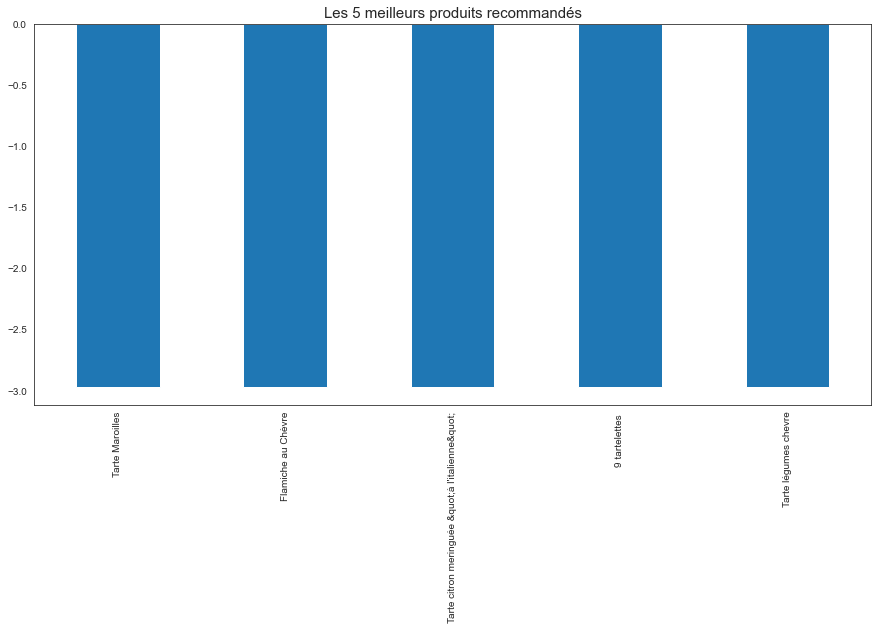

'Tarte Maroilles'

******************************************************************************************************************************************************


'Flamiche au Chèvre'

******************************************************************************************************************************************************


"Tarte citron meringuée &quot;à l'italienne&quot;"

******************************************************************************************************************************************************


'9 tartelettes '

******************************************************************************************************************************************************


'Tarte légumes chevre'

image de produit non disponible
******************************************************************************************************************************************************


In [50]:
# Tartes
liste_groupe_produits = data_france['main_category_fr'].value_counts().index.to_list()[:100]
print ('Liste des groupes de produits disponibles : \n', liste_groupe_produits)
print(100*'*')
groupe_produit = input('Choisir le nom du produit que vous voulez acheter de cette liste :\n')
print(100*'*')
if  groupe_produit in liste_groupe_produits:
    print('La categorie du produit que vous avez choisi est :', groupe_produit)
    recommandation(groupe_produit)
else:
    print('La categorie du produit que vous avez choisi n\'est pas dans la liste donnée')

In [51]:
# ghef
liste_groupe_produits = data_france['main_category_fr'].value_counts().index.to_list()[:100]
print ('Liste des groupes de produits disponibles : \n', liste_groupe_produits)
print(100*'*')
groupe_produit = input('Choisir le nom du produit que vous voulez acheter de cette liste :\n')
print(100*'*')
if  groupe_produit in liste_groupe_produits:
    print('La categorie du produit que vous avez choisi est :', groupe_produit)
    recommandation(groupe_produit)
else:
    print('La categorie du produit que vous avez choisi n\'est pas dans la liste donnée')

Liste des groupes de produits disponibles : 
 ['unknown', 'Boissons', 'Conserves', 'Epicerie', 'Chocolats', 'Biscuits', 'Aliments et boissons à base de végétaux', 'Surgelés', 'Petit-déjeuners', 'Desserts', 'Snacks sucrés', 'Plats à base de viande', 'Pains', 'Pâtes alimentaires', 'Gâteaux', 'Produits à tartiner salés', 'Fromages', 'Chips et frites', 'Bonbons', 'Soupes', 'Confitures', 'Snacks salés', 'Fromages de France', 'Condiments', "Produits d'élevages", 'Sandwichs', 'Volailles', 'Viandes', 'Légumes frais', 'Glaces', 'Laits', 'Fruits à coques', 'Fruits', 'Eaux', 'Aliments pour bébé', 'Epices', 'Yaourts', 'Jambons', 'Sodas', 'Fromages de vache', 'Saucissons', 'Saucisses', 'Riz', 'Produits labellisés', 'Beurres', 'Jus de fruits', 'Produits panés', 'Charcuteries', 'Saumons', 'Crèmes', 'Sardines en conserve', 'Salades composées', 'Nectars de fruits', 'Poissons', 'Pâtes à tartiner', 'Jus de fruits 100% pur jus', 'Fruits secs', 'Thons', 'Yaourts aux fruits', 'Produits de la mer', 'Huiles',